In [63]:
import os
import gc

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [64]:
# !pip install pyarrow

In [65]:
# train = pd.read_csv('c:/data/project/train.csv')
# test = pd.read_csv('c:/data/project/test.csv')

## Data Preprocessing

In [66]:
# # parquet으로 저장 함수, csv보다 매우 빠르게 데이터 처리가 가능합니다 :)
## Convert CSV files to Parquet format for faster data reading and processing
def csv_to_parquet(csv_path, save_name):
    df = pd.read_csv(csv_path)
    df.to_parquet(f'./{save_name}.parquet')
    del df
    gc.collect()
    print(save_name, 'Done.')

In [67]:
csv_to_parquet('c:/data/project/train.csv', 'train')
csv_to_parquet('c:/data/project/test.csv', 'test')

train = pd.read_parquet('train.parquet')
test = pd.read_parquet('test.parquet')
sample_submission = pd.read_csv('c:/data/project/sample_submission.csv', index_col = 0)

train Done.
test Done.


In [68]:
# train 복사
train1 = train.copy()
train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2478 entries, 0 to 2477
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID                  2478 non-null   object
 1   first_party         2478 non-null   object
 2   second_party        2478 non-null   object
 3   facts               2478 non-null   object
 4   first_party_winner  2478 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 96.9+ KB


In [69]:
train1.drop(columns=['ID','first_party', 'second_party'], inplace=True)

In [70]:
train1.head()

,facts,first_party_winner
0,"On June 27, 1962, Phil St. Amant, a candidate ...",1
1,Ramon Nelson was riding his bike when he suffe...,0
2,An Alabama state court convicted Billy Joe Mag...,1
3,Victor Linkletter was convicted in state court...,0
4,"On April 24, 1953 in Selma, Alabama, an intrud...",1


In [71]:
df = train1[['facts', 'first_party_winner']]
df_target = df[['first_party_winner']]
df_nlp = df[['facts']]
df_nlp1 = pd.DataFrame(df_nlp, columns=['facts'])
df_nlp1['facts'] = df_nlp1['facts'].str.replace(r'<[^<>]*>', '', regex=True)
# df_target
df_nlp1

,facts
0,"On June 27, 1962, Phil St. Amant, a candidate ..."
1,Ramon Nelson was riding his bike when he suffe...
2,An Alabama state court convicted Billy Joe Mag...
3,Victor Linkletter was convicted in state court...
4,"On April 24, 1953 in Selma, Alabama, an intrud..."
...,...
2473,Congress amended the Clean Air Act through the...
2474,"Alliance Bond Fund, Inc., an investment fund, ..."
2475,"In 1992, the District Court sentenced Manuel D..."
2476,"On March 8, 1996, Enrico St. Cyr, a lawful per..."


In [72]:
# !pip install nltk

In [73]:
# import nltk
# nltk.download()

In [74]:
from nltk.tokenize import WhitespaceTokenizer
# 공백 단위로 쪼개기
corpus = df_nlp1["facts"]
Tokenizer=WhitespaceTokenizer()
lst_tokens = Tokenizer.tokenize(str(corpus))
lst_tokens

['0',
 'On',
 'June',
 '27,',
 '1962,',
 'Phil',
 'St.',
 'Amant,',
 'a',
 'candidate',
 '...',
 '1',
 'Ramon',
 'Nelson',
 'was',
 'riding',
 'his',
 'bike',
 'when',
 'he',
 'suffe...',
 '2',
 'An',
 'Alabama',
 'state',
 'court',
 'convicted',
 'Billy',
 'Joe',
 'Mag...',
 '3',
 'Victor',
 'Linkletter',
 'was',
 'convicted',
 'in',
 'state',
 'court...',
 '4',
 'On',
 'April',
 '24,',
 '1953',
 'in',
 'Selma,',
 'Alabama,',
 'an',
 'intrud...',
 '...',
 '2473',
 'Congress',
 'amended',
 'the',
 'Clean',
 'Air',
 'Act',
 'through',
 'the...',
 '2474',
 'Alliance',
 'Bond',
 'Fund,',
 'Inc.,',
 'an',
 'investment',
 'fund,',
 '...',
 '2475',
 'In',
 '1992,',
 'the',
 'District',
 'Court',
 'sentenced',
 'Manuel',
 'D...',
 '2476',
 'On',
 'March',
 '8,',
 '1996,',
 'Enrico',
 'St.',
 'Cyr,',
 'a',
 'lawful',
 'per...',
 '2477',
 'Herbert',
 'Markman',
 'owns',
 'the',
 'patent',
 'to',
 'a',
 'system',
 'th...',
 'Name:',
 'facts,',
 'Length:',
 '2478,',
 'dtype:',
 'object']

In [75]:
import nltk

# 어절 별로 쪼개기
corpus = df_nlp1["facts"]
lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))

ps = nltk.stem.porter.PorterStemmer()
lem = nltk.stem.wordnet.WordNetLemmatizer()

lst_tokens

['On',
 'June',
 '27',
 ',',
 '1962',
 ',',
 'Phil',
 'St.',
 'Amant',
 ',',
 'a',
 'candidate',
 'for',
 'public',
 'office',
 ',',
 'made',
 'a',
 'television',
 'speech',
 'in',
 'Baton',
 'Rouge',
 ',',
 'Louisiana',
 '.',
 'During',
 'this',
 'speech',
 ',',
 'St.',
 'Amant',
 'accused',
 'his',
 'political',
 'opponent',
 'of',
 'being',
 'a',
 'Communist',
 'and',
 'of',
 'being',
 'involved',
 'in',
 'criminal',
 'activities',
 'with',
 'the',
 'head',
 'of',
 'the',
 'local',
 'Teamsters',
 'Union',
 '.',
 'Finally',
 ',',
 'St.',
 'Amant',
 'implicated',
 'Herman',
 'Thompson',
 ',',
 'an',
 'East',
 'Baton',
 'Rouge',
 'deputy',
 'sheriff',
 ',',
 'in',
 'a',
 'scheme',
 'to',
 'move',
 'money',
 'between',
 'the',
 'Teamsters',
 'Union',
 'and',
 'St.',
 'Amant',
 '’',
 's',
 'political',
 'opponent',
 '.',
 'Thompson',
 'successfully',
 'sued',
 'St.',
 'Amant',
 'for',
 'defamation',
 '.',
 'Louisiana',
 '’',
 's',
 'First',
 'Circuit',
 'Court',
 'of',
 'Appeals',
 'reve

In [76]:
lst_stopwords = nltk.corpus.stopwords.words("english")
# NLTK가 정의한 영어 불용어 리스트를 리턴
lst_stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [77]:
 
user_stopwords = ["circuit","district", "law", "court", "case", "plaintiff", "defendant", "judge", "trial", "jurisdiction", "evidence", "witness", "proceeding", "litigation", "party", "motion", "appeal", "action", "suit", "claim", "issue", "fact", "hearing", "counsel", "judgment", "order", "allegation", "argument", "brief", "charge", "complaint", "contract", "crime", "decision", "defense", "document", "file", "find", "hold", "injunction", "instruction", "lawyer", "legal", "liability", "matter", "notice", "opinion", "party", "plea", "point", "policy", "practice", "present", "prosecution", "record", "rule", "sentence", "statute", "testimony", "verdict", 'james', 'bike', 'named',"section", "act", "article", "chapter", "provision", "paragraph", "amendment", "code", "regulation", "statutory", "subsection", "constitution", "legislation", "ordinance", "regulatory", "rulemaking", "title", "enactment", "resolution", "treaty", "administrative", "bylaw",  "legislative", "prescription", "ratification", "repeal", "statutorily", "adjudicate", "adjudication", "arbitrate", "arbitration", "conciliation", "decree", "litigate", "mediation", "remand", "tribunal", "appellate", "affirm", "overrule", "reversal", "vacate", "writ", "certiorari", "mandamus", "subpoena", "arraignment", "indictment", "misdemeanor", "probation", "restitution", "summons", "verdict", "acquittal", "bail", "contempt", "conviction", "felony", "parole", "plea", "prosecutor", "sentence", "attorney", "barrister", "counsel", "juror", "litigator", "magistrate", "prosecutor", "solicitor", "stipulation", "testator", "trustee", "executor", "heir", "lease", "lessor", "lessee", "mortgagee", "mortgagor", "assignee", "assignor", "debtor", "creditor", "insurer", "insured", "beneficiary", "fiduciary", "principal", "agent"]
user_stopwords

['circuit',
 'district',
 'law',
 'court',
 'case',
 'plaintiff',
 'defendant',
 'judge',
 'trial',
 'jurisdiction',
 'evidence',
 'witness',
 'proceeding',
 'litigation',
 'party',
 'motion',
 'appeal',
 'action',
 'suit',
 'claim',
 'issue',
 'fact',
 'hearing',
 'counsel',
 'judgment',
 'order',
 'allegation',
 'argument',
 'brief',
 'charge',
 'complaint',
 'contract',
 'crime',
 'decision',
 'defense',
 'document',
 'file',
 'find',
 'hold',
 'injunction',
 'instruction',
 'lawyer',
 'legal',
 'liability',
 'matter',
 'notice',
 'opinion',
 'party',
 'plea',
 'point',
 'policy',
 'practice',
 'present',
 'prosecution',
 'record',
 'rule',
 'sentence',
 'statute',
 'testimony',
 'verdict',
 'james',
 'bike',
 'named',
 'section',
 'act',
 'article',
 'chapter',
 'provision',
 'paragraph',
 'amendment',
 'code',
 'regulation',
 'statutory',
 'subsection',
 'constitution',
 'legislation',
 'ordinance',
 'regulatory',
 'rulemaking',
 'title',
 'enactment',
 'resolution',
 'treaty',
 '

In [78]:
import re

def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None, user_stopwords=None): 
## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
        
    if user_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    user_stopwords]
                        
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [79]:
df_nlp1["facts_clean"] = df_nlp1["facts"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords, user_stopwords=user_stopwords))

df_nlp1

,facts,facts_clean
0,"On June 27, 1962, Phil St. Amant, a candidate ...",june 27 1962 phil st amant candidate public of...
1,Ramon Nelson was riding his bike when he suffe...,ramon nelson riding suffered lethal blow back ...
2,An Alabama state court convicted Billy Joe Mag...,alabama state convicted billy joe magwood murd...
3,Victor Linkletter was convicted in state court...,victor linkletter convicted state illegally ob...
4,"On April 24, 1953 in Selma, Alabama, an intrud...",april 24 1953 selma alabama intruder broke apa...
...,...,...
2473,Congress amended the Clean Air Act through the...,congress amended clean air energy 2005 effort ...
2474,"Alliance Bond Fund, Inc., an investment fund, ...",alliance bond fund inc investment fund purchas...
2475,"In 1992, the District Court sentenced Manuel D...",1992 sentenced manuel peguero 274 month impris...
2476,"On March 8, 1996, Enrico St. Cyr, a lawful per...",march 8 1996 enrico st cyr lawful permanent re...


In [80]:
df_nlp2 = pd.concat([df_nlp1,df_target['first_party_winner']],axis=1, join='inner')

df_nlp2["first_party_winner"].value_counts()
df_nlp2

,facts,facts_clean,first_party_winner
0,"On June 27, 1962, Phil St. Amant, a candidate ...",june 27 1962 phil st amant candidate public of...,1
1,Ramon Nelson was riding his bike when he suffe...,ramon nelson riding suffered lethal blow back ...,0
2,An Alabama state court convicted Billy Joe Mag...,alabama state convicted billy joe magwood murd...,1
3,Victor Linkletter was convicted in state court...,victor linkletter convicted state illegally ob...,0
4,"On April 24, 1953 in Selma, Alabama, an intrud...",april 24 1953 selma alabama intruder broke apa...,1
...,...,...,...
2473,Congress amended the Clean Air Act through the...,congress amended clean air energy 2005 effort ...,1
2474,"Alliance Bond Fund, Inc., an investment fund, ...",alliance bond fund inc investment fund purchas...,1
2475,"In 1992, the District Court sentenced Manuel D...",1992 sentenced manuel peguero 274 month impris...,0
2476,"On March 8, 1996, Enrico St. Cyr, a lawful per...",march 8 1996 enrico st cyr lawful permanent re...,0


In [81]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

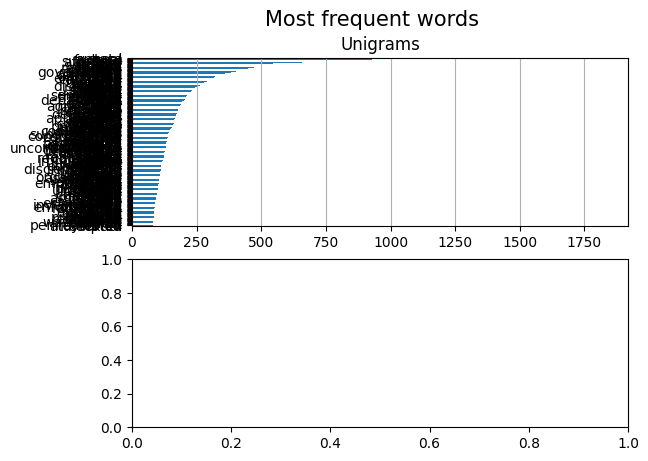

<Figure size 3000x2400 with 0 Axes>

'\ny = 1\ncorpus = df_nlp2[df_nlp2["first_party_winner"]== y]["facts_clean"]\nlst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))\nfig, ax = plt.subplots(nrows=2, ncols=1)\nfig.suptitle("Most frequent words", fontsize=15)\nfigure(figsize=(30, 24))\n## unigrams\ndic_words_freq = nltk.FreqDist(lst_tokens)\ndtf_uni = pd.DataFrame(dic_words_freq.most_common(), \n                    columns=["Word","Freq"])\ndtf_uni.set_index("Word").iloc[:20,:].sort_values(by="Freq").plot(\n                    kind="barh", title="Unigrams", ax=ax, \n                    legend=False).grid(axis=\'x\')\nax.set(ylabel=None)\nplt.show()    \n\ndtf_uni\n    \n## bigrams\n\ndic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 2))\ndtf_bi = pd.DataFrame(dic_words_freq.most_common(), \n                    columns=["Word","Freq"])\ndtf_bi["Word"] = dtf_bi["Word"].apply(lambda x: " ".join(\n                string for string in x) )\ndtf_bi.set_index("Word").iloc[:50,:].sort_values(by="Freq").plot(\n  

In [107]:
y = 1
corpus = df_nlp2[df_nlp2["first_party_winner"]== y]["facts_clean"]
lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))
fig, ax = plt.subplots(nrows=2, ncols=1)
fig.suptitle("Most frequent words", fontsize=15)
figure(figsize=(30, 24))
## unigrams
dic_words_freq = nltk.FreqDist(lst_tokens)
dtf_uni = pd.DataFrame(dic_words_freq.most_common(), 
                    columns=["Word","Freq"])
dtf_uni.set_index("Word").iloc[:300,:].sort_values(by="Freq").plot(
                    kind="barh", title="Unigrams", ax=ax[0], 
                    legend=False).grid(axis='x')
ax[0].set(ylabel=None)
plt.show()    
"""
y = 1
corpus = df_nlp2[df_nlp2["first_party_winner"]== y]["facts_clean"]
lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))
fig, ax = plt.subplots(nrows=2, ncols=1)
fig.suptitle("Most frequent words", fontsize=15)
figure(figsize=(30, 24))
## unigrams
dic_words_freq = nltk.FreqDist(lst_tokens)
dtf_uni = pd.DataFrame(dic_words_freq.most_common(), 
                    columns=["Word","Freq"])
dtf_uni.set_index("Word").iloc[:20,:].sort_values(by="Freq").plot(
                    kind="barh", title="Unigrams", ax=ax, 
                    legend=False).grid(axis='x')
ax.set(ylabel=None)
plt.show()    

dtf_uni
    
## bigrams

dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 2))
dtf_bi = pd.DataFrame(dic_words_freq.most_common(), 
                    columns=["Word","Freq"])
dtf_bi["Word"] = dtf_bi["Word"].apply(lambda x: " ".join(
                string for string in x) )
dtf_bi.set_index("Word").iloc[:50,:].sort_values(by="Freq").plot(
                kind="barh", title="Bigrams", ax=ax[1],
                legend=False).grid(axis='x')
ax[1].set(ylabel=None)
plt.show()
"""

In [83]:
corpus

0       june 27 1962 phil st amant candidate public of...
2       alabama state convicted billy joe magwood murd...
4       april 24 1953 selma alabama intruder broke apa...
5       new york town clarkstown allowed contractor co...
6       section immigration nationality require noncit...
                              ...                        
2469    increase use cocaine patient receiving prenata...
2470    school assembly approximately 600 high school ...
2471    october 2000 united state treasury department ...
2473    congress amended clean air energy 2005 effort ...
2474    alliance bond fund inc investment fund purchas...
Name: facts_clean, Length: 1649, dtype: object

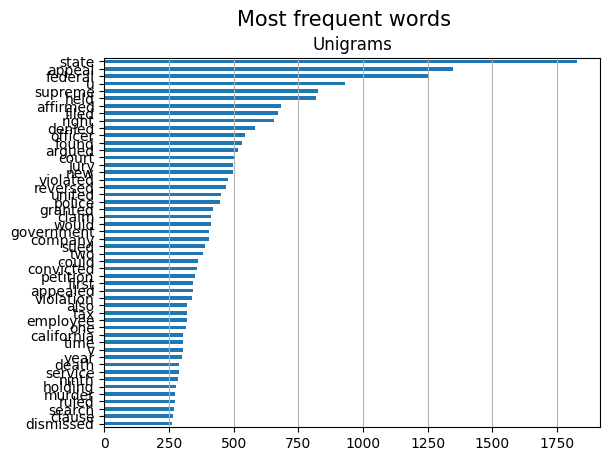

<Figure size 3000x2400 with 0 Axes>

,Word,Freq
0,state,1827
1,appeal,1348
2,federal,1250
3,u,930
4,supreme,826
...,...,...
14365,uninterrupted,1
14366,mexicano,1
14367,desarrollo,1
14368,insolvency,1


In [84]:
y=1
corpus0 = df_nlp2[df_nlp2["first_party_winner"]== y]["facts_clean"]
lst_tokens = nltk.tokenize.word_tokenize(corpus0.str.cat(sep=" "))

fig, ax = plt.subplots(nrows=1, ncols=1)
fig.suptitle("Most frequent words", fontsize=15)
figure(figsize=(30, 24))

dic_words_freq = nltk.FreqDist(lst_tokens)
dtf_uni0 = pd.DataFrame(dic_words_freq.most_common(), columns=["Word","Freq"])
# dtf_uni[40:60]
dtf_uni0.set_index("Word").iloc[:50,:].sort_values(by="Freq").plot(
                    kind="barh", title="Unigrams", ax=ax, 
                    legend=False).grid(axis='x')
ax.set(ylabel=None)
plt.show()   
dtf_uni

In [85]:
corpus0

0       june 27 1962 phil st amant candidate public of...
2       alabama state convicted billy joe magwood murd...
4       april 24 1953 selma alabama intruder broke apa...
5       new york town clarkstown allowed contractor co...
6       section immigration nationality require noncit...
                              ...                        
2469    increase use cocaine patient receiving prenata...
2470    school assembly approximately 600 high school ...
2471    october 2000 united state treasury department ...
2473    congress amended clean air energy 2005 effort ...
2474    alliance bond fund inc investment fund purchas...
Name: facts_clean, Length: 1649, dtype: object

In [86]:
!pip install wordcloud

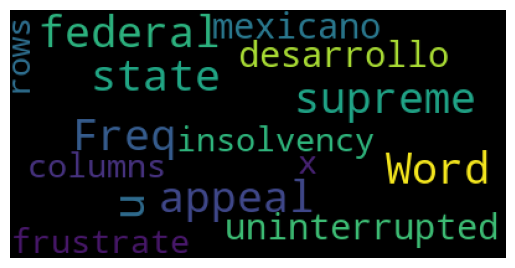

In [87]:
import wordcloud

wc = wordcloud.WordCloud(background_color='black', max_words=100, 
                        max_font_size=35)
wc = wc.generate(str(dtf_uni))
fig = plt.figure(num=1)
plt.axis('off')
plt.imshow(wc, cmap=None)
plt.show()

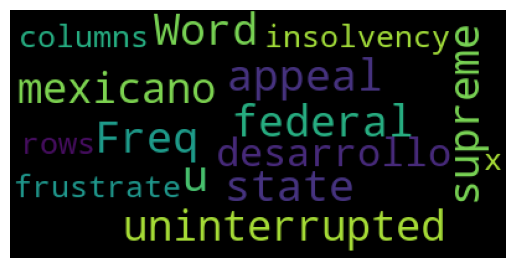

In [88]:
wc0 = wordcloud.WordCloud(background_color='black', max_words=100, 
                        max_font_size=35)
wc0 = wc0.generate(str(dtf_uni0))
fig = plt.figure(num=1)
plt.axis('off')
plt.imshow(wc0, cmap=None)
plt.show()

In [89]:
df_nlp2

xfeatures = df_nlp2['facts_clean']
ylabel = df_nlp2['first_party_winner']

In [90]:
from sklearn.model_selection import train_test_split

vectorizer = TfidfVectorizer()

X_train, X_test, y_train, y_test = train_test_split(xfeatures,ylabel, test_size=0.3)

In [91]:
X_train.count(), X_test.count(), y_train.count(), y_test.count()

(1734, 744, 1734, 744)

In [92]:
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

## Preprocessing ENDS && MODELING STARTS

#REGRESSION

In [93]:
lr = LogisticRegression(solver='liblinear')
lr.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [94]:
lr.score(X_test, y_test)

0.6451612903225806

#XGBoost

In [95]:
# !pip install xgboost

In [96]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

xgb = XGBClassifier(
                    booster = 'gbtree',
                    scale_pos_weight=5,
                    learning_rate=0.01,  
                    colsample_bytree = 0.7,
                    subsample = 0.5,
                    max_delta_step = 3,
                    reg_lambda = 2,
                    objective='binary:logistic',
                    n_estimators=818, 
                    max_depth=8,
                    )


xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=3,
              max_depth=8, max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=818, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [97]:
y_pred = xgb.predict_proba(X_test)
y_pred

array([[0.06643045, 0.93356955],
       [0.11218059, 0.8878194 ],
       [0.22683859, 0.7731614 ],
       ...,
       [0.06784904, 0.93215096],
       [0.08311504, 0.91688496],
       [0.06964284, 0.93035716]], dtype=float32)

In [98]:
xgb.score(X_test, y_test)

0.6518817204301075

In [99]:
tfidfv = TfidfVectorizer().fit(train['facts'])
print(tfidfv.vocabulary_)
print("="*100)
print(tfidfv.transform(train['facts']).toarray())
print("="*100)
print(tfidfv.fit_transform(train['facts']).toarray())

{'on': 11300, 'june': 8968, '27': 352, '1962': 233, 'phil': 11996, 'st': 14991, 'amant': 1383, 'candidate': 2920, 'for': 6763, 'public': 12745, 'office': 11251, 'made': 9834, 'television': 15696, 'speech': 14902, 'in': 8202, 'baton': 2158, 'rouge': 13907, 'louisiana': 9745, 'during': 5518, 'this': 15846, 'accused': 922, 'his': 7811, 'political': 12180, 'opponent': 11342, 'of': 11235, 'being': 2243, 'communist': 3652, 'and': 1456, 'involved': 8711, 'criminal': 4314, 'activities': 972, 'with': 17250, 'the': 15798, 'head': 7642, 'local': 9656, 'teamsters': 15662, 'union': 16453, 'finally': 6612, 'implicated': 8153, 'herman': 7738, 'thompson': 15850, 'an': 1433, 'east': 5570, 'deputy': 4845, 'sheriff': 14489, 'scheme': 14152, 'to': 15937, 'move': 10652, 'money': 10553, 'between': 2321, 'successfully': 15317, 'sued': 15326, 'defamation': 4640, 'first': 6651, 'circuit': 3355, 'court': 4233, 'appeals': 1564, 'reversed': 13694, 'holding': 7848, 'that': 15797, 'did': 5001, 'not': 11076, 'show':

In [100]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
#train_nlp2 = pd.concat([train_nlp,train_target['first_party_winner']],axis=1, join='inner')
xfeatures = df_nlp2['facts_clean']
ylabel = df_nlp2['first_party_winner']

In [101]:
vectorizer = TfidfVectorizer()
def get_vector(vectorizer, df, train_mode):
    if train_mode:
        X_facts = vectorizer.fit_transform(df['facts'])
    else:
        X_facts = vectorizer.transform(df['facts'])
    X_party1 = vectorizer.transform(df['first_party'])
    X_party2 = vectorizer.transform(df['second_party'])
    
    X = np.concatenate([X_party1.todense(), X_party2.todense(), X_facts.todense()], axis=1)
    return X

In [102]:
X_train = get_vector(vectorizer, train, True)
Y_train = train["first_party_winner"]
X_test = get_vector(vectorizer, test, False)

## Inference & Submission

In [103]:
submit = pd.read_csv('./sample_submission.csv')

In [104]:
pred = model.predict(X_test)

NameError: name 'model' is not defined

In [ ]:
submit['first_party_winner'] = pred
submit.to_csv('./baseline_submit.csv', index=False)
print('Done')

Done
